In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns; 
sns.set()

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import \
    classification_report, \
    plot_confusion_matrix, \
    confusion_matrix, \
    roc_curve, \
    auc
from tqdm import tqdm


ModuleNotFoundError: No module named 'mlxtend'

In [25]:
# Macros
PATH_DATA_TRAIN = '20_Percent_Training_Set.csv'
PATH_DATA_TEST = 'KDDTest+.csv'
PATH_DATA_FEATURES = 'Field_Names.csv'
PATH_DATA_ATTACK = 'Attack_Types.csv'

class IDs:
    """
        Data resource: https://github.com/defcom17/NSL_KDD
    """

    def __init__(self, mode='Anomaly'):
        self.import_features()
        self.import_data()
        self.mode = mode
        self.models = []
        
    def import_features(self):
        data = pd.read_csv(
            './data/' + PATH_DATA_FEATURES,
            header=None,
            names=['feature_name', 'data_type'])
        self.features_meta = data

    def import_data(self):
        # Last two columns indicate attack type and its severity
        target_features = np.array(['class', 'severity'])
        features = np.concatenate(
            (self.features_meta['feature_name'].values,
             target_features)
        )
        
        self.data_train = pd.read_csv(
            './data/' + PATH_DATA_TRAIN,
            names=features
        )
        self.data_test = pd.read_csv(
            './data/' + PATH_DATA_TEST,
            names=features
        )
        
    def import_attack_types(self):
        data = pd.read_csv(
            './data/' + PATH_DATA_ATTACK,
            header=None,
            names=['attack_name', 'attack_type'])
        types = {}
        for i in range(len(data)):
            types[str(data['attack_name'][i])] = str(data['attack_type'][i])
        self.attack_types = types
        
    def preprocess(self):
        # Drop the un-needed column
        self.data_train = self.data_train.drop(columns=['severity'])
        self.data_test = self.data_test.drop(columns=['severity'])
        
        # Drop the symbolic column
        symbolic = self.features_meta.loc[self.features_meta['data_type'] == 'symbolic']
        symbolic = symbolic['feature_name'].values
        self.data_train = self.data_train.drop(columns=symbolic)
        self.data_test = self.data_test.drop(columns=symbolic)
        # print(self.data_train.loc[self.data_train['class']=='normal'])
        
        # Extract normal for Anomaly Detection
        if self.mode == 'Anomaly':
            self.data_train = self.data_train[self.data_train['class'] == 'normal']
            
    def split(self):
        i = len(self.data_train.columns) - 1
        self.X_train = self.data_train.iloc[:, :i]
        self.y_train = self.data_train.iloc[:, i:]
        self.X_test = self.data_test.iloc[:, :i]
        self.y_test = self.data_test.iloc[:, i:]
        
        # Normalized data
        if self.mode == 'Anomaly' or self.mode == 'Misuse':
            self.X_train = normalize(self.X_train, axis=0, norm='max')
            self.X_test = normalize(self.X_test, axis=0, norm='max')

        # Convert class to binary
        self.y_train['class'] = (self.data_train['class'] != 'normal').astype(int)
        self.y_test['class'] = (self.data_test['class'] != 'normal').astype(int)
            
    def predict_nearests(self):
        nearests = []
        for i in tqdm(range(len(self.X_test))):
            distances = np.linalg.norm(self.X_train - self.X_test[i], axis=1)
            sorted_distances = np.sort(distances)
            sorted_ids = distances.argsort()
            nearest = [sorted_ids[0], distances[sorted_ids[0]]]
            #print('Nearest neighbor: (id, distacne) = ', nearest)
            nearests.append(nearest)
        return nearests
    
    def evaluate_nearests_by_threshold(self, nearests, plt_config=None):
        thresholds = self.compute_thresholds(nearests)
        y_dist = np.array([i[1] for i in nearests])
        for th in thresholds:    
            y_pred = y_dist.copy()

            y_pred[y_pred < th] = 0
            y_pred[y_pred >= th] = 1

            if plt_config:
                self.plot_ROC(ad.y_test, y_pred, plt_config)

    def evaluate_nearests_by_class(self, nearests, plt_config=None):
        # Convert predicted attack to its type
        nearest_ids = np.array([i[0] for i in nearests])
        y_pred = [self.data_train['class'][i] for i in nearest_ids]
        for i in range(len(y_pred)):
            y_pred[i] = self.attack_types[y_pred[i]]

        # Catorgorize attack in test data
        y_test = y_pred.copy()
        for i, key in enumerate(self.data_test['class']):
            if key in self.attack_types:
                y_test[i] = self.attack_types[key]
        
        return y_test, y_pred
        
    def construct_knn(self, args=None):
        if self.mode == 'Anomaly':
            self.X_train = self.data_train[self.data]
        model = KNeighborsClassifier(n_neighbors=args['n_neighbors'])
        model.fit(self.X_train, self.y_train)
        self.models.append(model)
        return model

    @staticmethod
    def compute_thresholds(nearests):
        thresholds = []
        threshold_range = [i[1] for i in nearests]
        threshold_range = [min(threshold_range), max(threshold_range)]
        print('Threshold Range: ', threshold_range)

        offset = (threshold_range[1] - threshold_range[0]) * 0.1
        for i in np.arange(threshold_range[0], threshold_range[1], offset):
            thresholds.append(i)
        print('Thresholds: ', thresholds)

        return thresholds

    @staticmethod
    def plot_ROC(y_test, y_pred, plt_config):    
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=plt_config['figsize'])
        plt.title('ROC for ' + plt_config['model'])
        plt.plot(fpr, tpr, 'b', label='ROC-AUC = %0.2f' % roc_auc)
        plt.plot([0,1], [0,1], 'y--', label='baseline')

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc='best')
        plt.show()
        
    def check_shape(self):
        #print(self.data_train.head())
        print('Train data shape: ', self.data_train.shape)
        print('Test data shape: ', self.data_test.shape)
        print('Data features: ', self.data_train.columns, len(self.data_train.columns))
        print('Shape of X_train, y_train, X_test, y_test: ',
              self.X_train.shape, self.y_train.shape, self.X_test.shape, self.y_test.shape)

In [26]:
# A.1
ad = IDs('Anomaly')
ad.preprocess()
ad.split()
ad.check_shape()

Train data shape:  (13449, 39)
Test data shape:  (22543, 39)
Data features:  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object') 39
Shape of X_train, y_train, X_test, y_test:  (13449, 38) (13449, 1) (22543, 38) (22543, 1)


# A. Anomaly Detection

(1) Extract normal instances from the training dataset; process the data according to the need as necessary; normalize the attribute values for better classification performance.

(2) For every instance in the testing dataset, find the nearest “neighbor” instance in the normal profile and calculate the corresponding distance to it.

In [27]:
# A.2
nearests = ad.predict_nearests()
print('Nearest neighbors = ', nearests[:5])

100%|██████████| 22543/22543 [00:46<00:00, 487.02it/s]

Nearest neighbors =  [[8073, 1.3940272867028123], [8073, 1.398023406443181], [11704, 0.047388972828311504], [9857, 0.36566526415352013], [10738, 0.8093912662149911]]


(3) Vary the control threshold to appropriately cover the value range of this distance (using at least 10 different values), and classify each new instance as normal or attack (binary classification) accordingly.

(4) Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) pair for each control threshold value used and plot the Receiver Operating Characteristic (ROC) curve.

(5) Please calculate the Area Under the Curve (AUC) for this ROC.

Threshold Range:  [5.512885536068322e-05, 2.0624348053245796]
Thresholds:  [5.512885536068322e-05, 0.20629309650228259, 0.4125310641492045, 0.6187690317961263, 0.8250069994430482, 1.0312449670899702, 1.237482934736892, 1.443720902383814, 1.649958870030736, 1.8561968376776579]


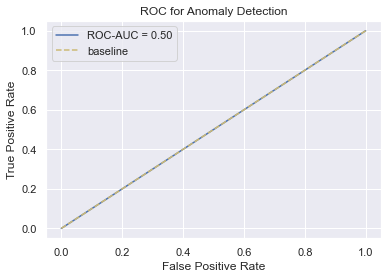

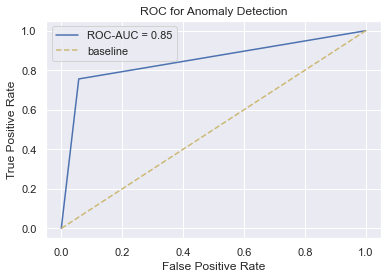

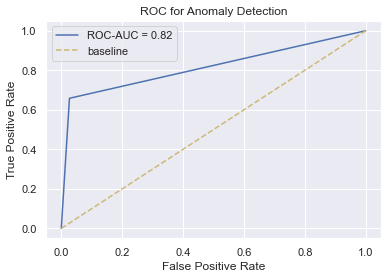

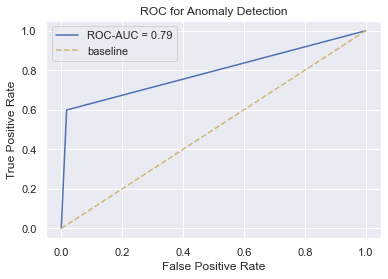

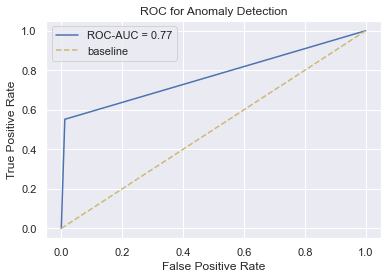

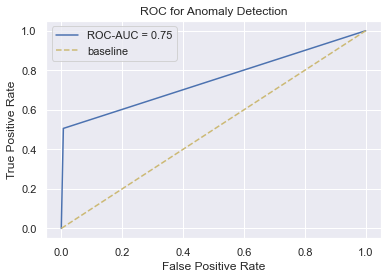

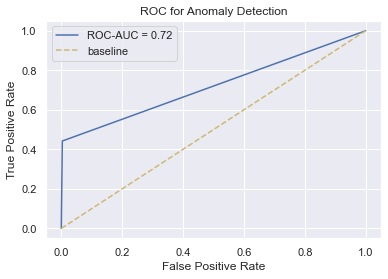

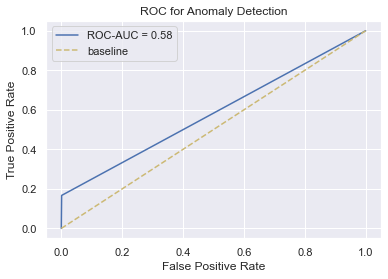

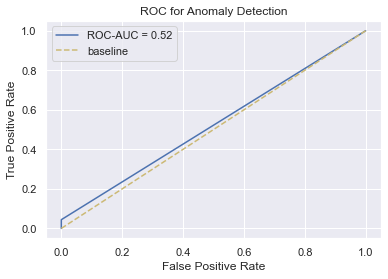

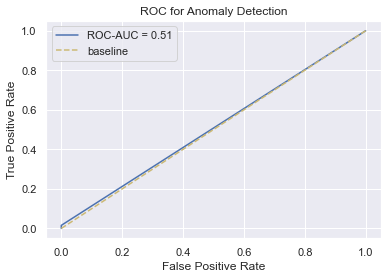

In [28]:
# Customize plot
plt_config = {
    'figsize': (6, 4),
    'model': ad.mode + ' Detection'
}

# A.3 ~ 5
ad.evaluate_nearests_by_threshold(nearests, plt_config)

(6) Please find the “best” control threshold setting and explain how you determine it.

# B. Misuse Detection

(1) Use the whole training dataset (both normal and intrusive instances) for detection.

In [29]:
# B.1
md = IDs('Misuse')
md.preprocess()
md.split()
md.check_shape()

Train data shape:  (25192, 39)
Test data shape:  (22543, 39)
Data features:  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object') 39
Shape of X_train, y_train, X_test, y_test:  (25192, 38) (25192, 1) (22543, 38) (22543, 1)


In [ ]:
# print(ids.X_train.shape)
# print(ids.X_train.head())
# print(ids.y_train.shape)
# print(ids.y_train.head())

(2) Select different k’s (using at least the first 10 odd integer numbers) used in k-NN classification, through majority voting, to classify each instance in the testing dataset as normal or intrusive (binary classification).

(3) Calculate the FPR and TPR pair for each k used and plot the ROC curve over these different k’s.

(4) Please calculate the AUC for this ROC.

  0%|          | 0/10 [00:00<?, ?it/s]

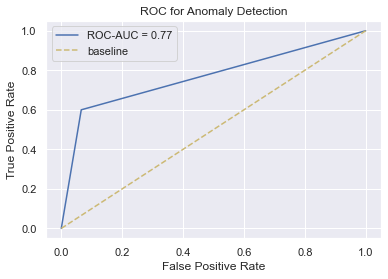

 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

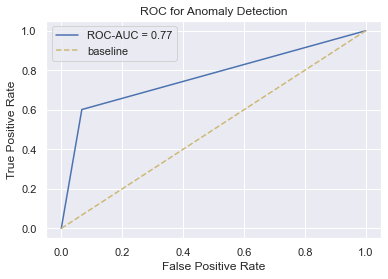

 20%|██        | 2/10 [00:12<00:52,  6.60s/it]

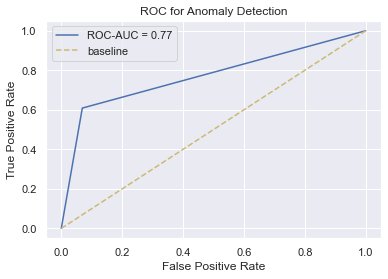

 30%|███       | 3/10 [00:23<00:57,  8.28s/it]

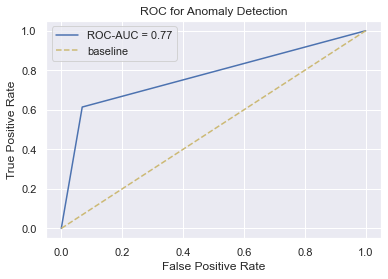

 40%|████      | 4/10 [00:32<00:53,  8.91s/it]

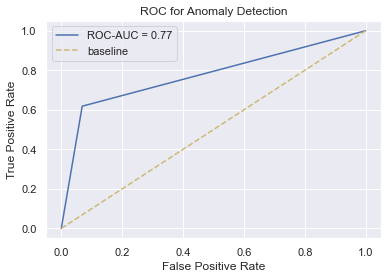

 50%|█████     | 5/10 [00:43<00:46,  9.34s/it]

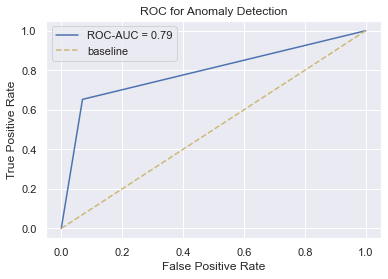

 60%|██████    | 6/10 [00:53<00:38,  9.57s/it]

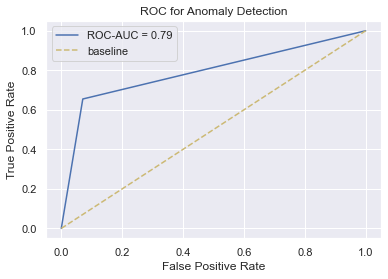

 70%|███████   | 7/10 [01:02<00:28,  9.54s/it]

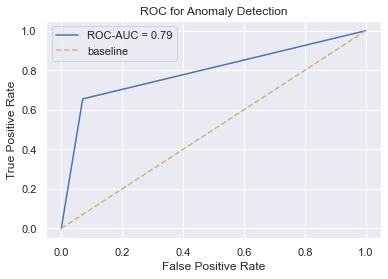

 80%|████████  | 8/10 [01:12<00:19,  9.54s/it]

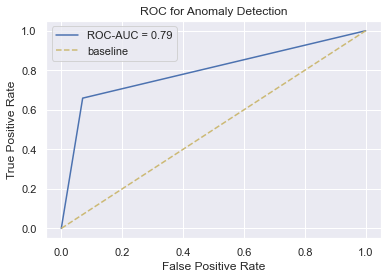

 90%|█████████ | 9/10 [01:21<00:09,  9.52s/it]

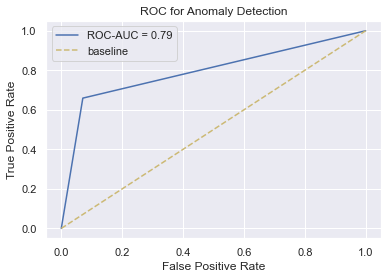

100%|██████████| 10/10 [01:31<00:00,  9.11s/it]


In [32]:
# Customize plot
plt_config = {
    'figsize': (6, 4),
    'model': ad.mode + ' Detection'
}

# B.2 ~ 4
neighbors = [k for k in range(1, 20, 2)]
for k in tqdm(neighbors):
    it = md.construct_knn({'n_neighbors': k})
    y_pred = it.predict(md.X_test)
    md.plot_ROC(md.y_test, y_pred, plt_config)

(5) Now, use the nearest neighbor method, i.e., k=1, to find the attack category (using the four attack categories) or normal category of each testing instance, and show the resulting confusion matrix.

In [33]:
# B.5
md.import_attack_types()
nearests = md.predict_nearests()

100%|██████████| 22543/22543 [01:38<00:00, 229.95it/s]


In [34]:
y_test, y_pred = md.evaluate_nearests_by_class(nearests)
print(classification_report(y_test, y_pred, target_names=['class-0', 'class-1', 'class-2', 'class-3', 'class-4']))


              precision    recall  f1-score   support

     class-0       0.92      0.93      0.93      6153
     class-1       0.82      0.95      0.88     12252
     class-2       0.79      0.85      0.82      1875
     class-3       0.95      0.04      0.08      2221
     class-4       0.67      0.14      0.24        42

    accuracy                           0.84     22543
   macro avg       0.83      0.58      0.59     22543
weighted avg       0.86      0.84      0.81     22543



In [46]:
target_names = ['normal', 'dos', 'r2l', 'probe','u2r']

print(y_pred[:10])
print(y_test[:10])

tempp = y_pred[:10]
tempt = y_test[:10]

# cm = confusion_matrix(y_test, y_pred, labels=target_names)
cm = confusion_matrix(tempt, tempp, labels=target_names)

print(cm)

print(md.attack_types)

['dos', 'dos', 'normal', 'probe', 'normal', 'normal', 'normal', 'normal', 'normal', 'probe']
['dos', 'dos', 'normal', 'probe', 'normal', 'normal', 'normal', 'r2l', 'normal', 'r2l']
[[5 0 0 0 0]
 [0 2 0 0 0]
 [1 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]
{'back': 'dos', 'buffer_overflow': 'u2r', 'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'ipsweep': 'probe', 'land': 'dos', 'loadmodule': 'u2r', 'multihop': 'r2l', 'neptune': 'dos', 'nmap': 'probe', 'perl': 'u2r', 'phf': 'r2l', 'pod': 'dos', 'portsweep': 'probe', 'rootkit': 'u2r', 'satan': 'probe', 'smurf': 'dos', 'spy': 'r2l', 'teardrop': 'dos', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'normal': 'normal', 'unknown': 'unknown'}


(6) Lastly, please use the cost matrix for the KDD’99 contest to calculate your average cost score. Now you can compare your performance to other entries in that contest!